# Modelo de Regresión con Validación Cruzada

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

In [16]:
# 1. Cargar los datos
df = pd.read_csv('../../train.csv')

# 2. En lugar de categorizar los precios, usaremos SalePrice directamente como variable objetivo
# para la regresión
print(f"Precio de venta mínimo: ${int(df['SalePrice'].min()):,}")
print(f"Precio de venta máximo: ${int(df['SalePrice'].max()):,}")
print(f"Precio de venta promedio: ${int(df['SalePrice'].mean()):,}")

# 3. Seleccionar las características para el modelo (mismas que en el modelo de clasificación)
selected_features = [
    'OverallQual',    # Calidad general
    'GrLivArea',      # Área habitable
    'GarageCars',     # Capacidad del garaje
    'YearBuilt',      # Año de construcción
    'TotalBsmtSF',    # Superficie total del sótano
    'FullBath',       # Baños completos
    'Neighborhood',   # Vecindario (categórica)
    'ExterQual',      # Calidad del exterior (categórica)
    'KitchenQual',    # Calidad de la cocina (categórica)
    'BsmtQual'        # Calidad del sótano (categórica)
]

# 4. Preparar los datos
X = df[selected_features].copy()
y = df['SalePrice']  # Variable objetivo continua para regresión

# Manejar valores faltantes en características numéricas
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
imputer = SimpleImputer(strategy='median')
X[numeric_features] = imputer.fit_transform(X[numeric_features])

# Manejar valores faltantes en características categóricas
categorical_features = X.select_dtypes(include=['object']).columns
X[categorical_features] = X[categorical_features].fillna('None')

# Codificar variables categóricas
encoders = {}
for feature in categorical_features:
    le = LabelEncoder()
    X[feature] = le.fit_transform(X[feature])
    encoders[feature] = le

# 5. Estandarizar las características numéricas (importante para KNN)
scaler = StandardScaler()
X[numeric_features] = scaler.fit_transform(X[numeric_features])

# 6. Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)




Precio de venta mínimo: $34,900
Precio de venta máximo: $755,000
Precio de venta promedio: $180,921


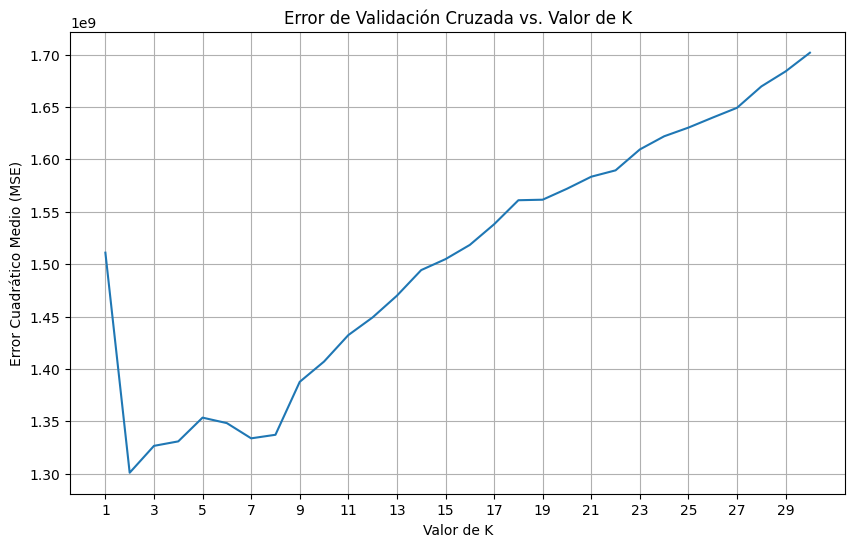

Mejor valor de k: 2


In [12]:
# Definir el modelo KNN para regresión
knn_regressor = KNeighborsRegressor()

# Configurar validación cruzada (k-fold)
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Realizar validación cruzada para evaluar diferentes valores de k (número de vecinos)
k_range = list(range(1, 31))
k_scores = []

for k in k_range:
    knn = KNeighborsRegressor(n_neighbors=k)
    # Usamos el negativo del error cuadrático medio como métrica
    scores = cross_val_score(knn, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
    k_scores.append(-scores.mean())  # Convertimos a positivo para facilitar la interpretación

# Visualizar los resultados de la validación cruzada
plt.figure(figsize=(10, 6))
plt.plot(k_range, k_scores)
plt.xlabel('Valor de K')
plt.ylabel('Error Cuadrático Medio (MSE)')
plt.title('Error de Validación Cruzada vs. Valor de K')
plt.xticks(k_range[::2])  # Mostrar cada segundo valor en el eje X
plt.grid(True)
plt.show()

# Encontrar el mejor valor de k
best_k = k_range[np.argmin(k_scores)]
print(f"Mejor valor de k: {best_k}")

In [13]:
# Definir la cuadrícula de parámetros
param_grid = {
    'n_neighbors': list(range(1, 21)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # p=1 para distancia Manhattan, p=2 para distancia Euclidiana
}

# Configurar GridSearchCV
grid_search = GridSearchCV(
    KNeighborsRegressor(),
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1  # Usar todos los núcleos disponibles
)

# Ajustar el modelo
grid_search.fit(X_train, y_train)

# Imprimir los mejores parámetros
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)

# Obtener el mejor modelo
best_knn = grid_search.best_estimator_


Mejores parámetros encontrados:
{'n_neighbors': 4, 'p': 1, 'weights': 'distance'}


In [14]:
# Evaluación con validación cruzada
cv_scores = cross_val_score(best_knn, X, y, cv=5, scoring='neg_mean_squared_error')
rmse_cv = np.sqrt(-cv_scores)

print("Resultados de la validación cruzada (RMSE):")
for i, rmse in enumerate(rmse_cv):
    print(f"Fold {i+1}: ${int(rmse):,}")
print(f"RMSE promedio: ${int(rmse_cv.mean()):,}")
print(f"Desviación estándar: ${int(rmse_cv.std()):,}")

# Predecir en el conjunto de prueba con el mejor modelo
y_pred = best_knn.predict(X_test)

# Calcular métricas de evaluación
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nResultados en el conjunto de prueba:")
print(f"Error cuadrático medio (MSE): ${int(mse):,}")
print(f"Raíz del error cuadrático medio (RMSE): ${int(rmse):,}")
print(f"Error absoluto medio (MAE): ${int(mae):,}")
print(f"Coeficiente de determinación (R²): {r2:.4f}")

Resultados de la validación cruzada (RMSE):
Fold 1: $30,445
Fold 2: $35,179
Fold 3: $34,596
Fold 4: $29,223
Fold 5: $34,290
RMSE promedio: $32,747
Desviación estándar: $2,426

Resultados en el conjunto de prueba:
Error cuadrático medio (MSE): $932,138,290
Raíz del error cuadrático medio (RMSE): $30,530
Error absoluto medio (MAE): $19,854
Coeficiente de determinación (R²): 0.8664


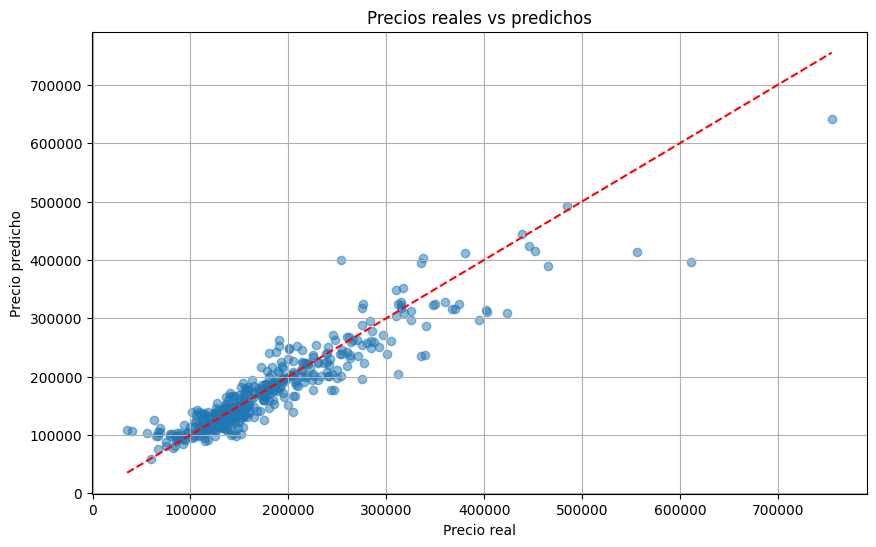

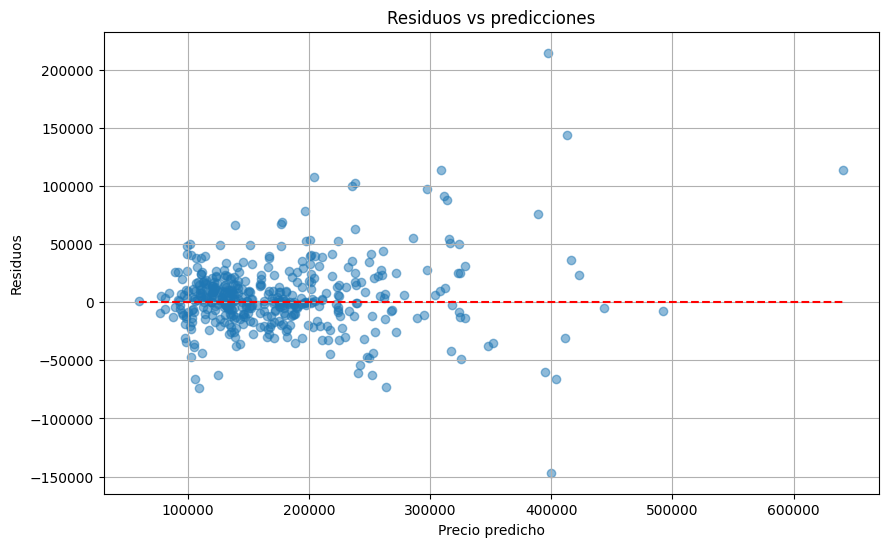

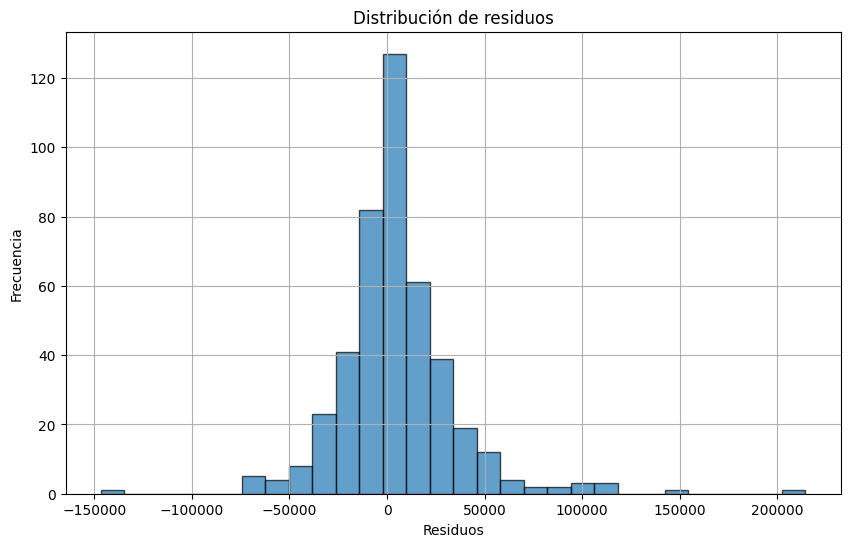

In [15]:
# Visualizar predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Precio real')
plt.ylabel('Precio predicho')
plt.title('Precios reales vs predichos')
plt.grid(True)
plt.show()

# Visualizar los residuos
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='r', linestyles='--')
plt.xlabel('Precio predicho')
plt.ylabel('Residuos')
plt.title('Residuos vs predicciones')
plt.grid(True)
plt.show()

# Histograma de residuos
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.title('Distribución de residuos')
plt.grid(True)
plt.show()

# Modelo de Clasificación con Validación Cruzada